<a href="https://colab.research.google.com/github/duke-sunshine/Algorithmic-Trading/blob/main/Session_1_Simple_Moving_Average_Rule.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Import Data 



1.   Install the Alpha Vantage API
2.   [Claim your own API Key](https://www.alphavantage.co/support/#api-key)
3.   [Import data from Time Series Stock APIs by specifiying API key and Parameters](https://www.alphavantage.co/documentation/)



Install Alpha Vantage Package

In [112]:
pip install alpha_vantage

In [113]:
from alpha_vantage.timeseries import TimeSeries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

Program import data class 

In [114]:
class Data:
  def __init__(self,API_key, symbol, interval):
    self.API_key = API_key
    self.symbol = symbol
    self.interval = interval
  def import_data(self):
    ts = TimeSeries(key=self.API_key, output_format='pandas')
    data=ts.get_intraday(self.symbol, interval = self.interval, outputsize = 'full') # We use 5-min interval to determine the time when traders make investment decisions.
    data[0].rename(columns={'1. open':'open', '2. high':'high', '3. low':'low', '4. close':'close', '5. volume':'volume'}, inplace = True)
    df = data[0]
    return df

return data with specified API and parameters: 

we use Tesla (TSLA) and Apple (AAPL) with 5-min time interval as case studies.  

In [115]:
TSLA=Data('YDWAVBLTFDZ3T4I7','TSLA','5min')
df_TSLA=TSLA.import_data()
df_TSLA.head()

,open,high,low,close,volume
date,,,,,
2021-08-06 20:00:00,697.30,697.42,697.00,697.00,7977.0
2021-08-06 19:55:00,696.90,697.40,696.90,697.19,2793.0
2021-08-06 19:50:00,697.00,697.00,696.85,696.85,2033.0
2021-08-06 19:45:00,697.00,697.00,697.00,697.00,2228.0
2021-08-06 19:40:00,697.53,697.53,697.00,697.00,3195.0


In [116]:
AAPL=Data('YDWAVBLTFDZ3T4I7','AAPL','5min')
df_AAPL=AAPL.import_data()
df_AAPL.head()

,open,high,low,close,volume
date,,,,,
2021-08-06 20:00:00,145.99,145.99,145.96,145.96,6012.0
2021-08-06 19:55:00,145.99,145.99,145.98,145.98,973.0
2021-08-06 19:50:00,145.99,145.99,145.98,145.98,323.0
2021-08-06 19:45:00,145.98,145.98,145.97,145.97,865.0
2021-08-06 19:40:00,145.95,145.97,145.94,145.97,602.0


# 2. Generate buy and sell signals with Visualizations

Program the signal class

https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.rolling.html

The Simple moving average with window $n$ at time $t$:

$SMA_t^n=\frac{1}{n}\sum_{i=t-n+1}^{t}p_i$

In [117]:
class signal:
  def __init__(self, data, short_window, long_window):
    self.data = data
    self.short_window = short_window
    self.long_window = long_window
  def signals(self):
    signals = pd.DataFrame(index=self.data.index)
    signals = signals.sort_values(by='date')
    signals['signal'] = 0.0
    signals['short_ma'] = self.data['close'].rolling(window=self.short_window, min_periods=self.short_window, center=True, closed='right').mean()
    signals['long_ma'] = self.data['close'].rolling(window=self.long_window, min_periods=self.long_window, center=True, closed='right').mean()  
    signals['signal'][self.short_window:] = np.where(signals['short_ma'][self.short_window:]>signals['long_ma'][self.short_window:], 1.0, 0.0)     
    signals['positions'] = signals['signal'].diff()
    signals =signals.dropna()
    return signals

Return sigals with input data and short and long windows. 

We use Tesla (TSLA) and Apple (AAPL) with 5-min time interval as case studies.

Short_window =5

Long_window =30

In [118]:
SMA_TSLA = signal(df_TSLA, 5, 30)
Signal_TSLA =SMA_TSLA.signals()
Signal_TSLA.head()

,signal,short_ma,long_ma,positions
date,,,,
2021-07-12 05:20:00,1.0,663.830,662.811000,1.0
2021-07-12 05:40:00,1.0,663.240,662.874667,0.0
2021-07-12 06:10:00,0.0,662.830,662.841333,-1.0
2021-07-12 06:15:00,0.0,662.532,662.799667,0.0
2021-07-12 06:25:00,0.0,662.052,662.733000,0.0


In [119]:
SMA_AAPL = signal(df_AAPL, 5, 30)
Signal_AAPL =SMA_AAPL.signals()
Signal_AAPL.head()

,signal,short_ma,long_ma,positions
date,,,,
2021-07-12 05:15:00,1.0,145.32922,145.246000,1.0
2021-07-12 05:20:00,1.0,145.32124,145.259313,0.0
2021-07-12 05:25:00,1.0,145.31924,145.270630,0.0
2021-07-12 05:30:00,1.0,145.31924,145.279950,0.0
2021-07-12 05:35:00,1.0,145.31524,145.278287,0.0


define signal visualization class

In [161]:
class signal_figure:
  def __init__(self, prices, signals):
    self.prices = prices
    self.signals = signals
  def signal_figure(self):
    close = self.prices['close']
    close = close.to_frame()
    close = close.merge(self.signals,how='inner',left_index=True, right_index=True)
    close = close.sort_values(by='date')
    fig = plt.figure(figsize = (18,8))
    plt.plot(close.close, color='g', lw=1., label = 'Stock Price')
    plt.plot(close.short_ma, color='r', lw=1., label = 'Short Window Moving Average')
    plt.plot(close.long_ma, color='b', lw=1., label = 'Long Window Moving Average')
    plt.plot(close.loc[close.positions == 1.0].index, close.short_ma[close.positions == 1.0], '^', markersize=5, color='green',label = 'buying signal')
    plt.plot(close.loc[close.positions == -1.0].index, close.long_ma[close.positions == -1.0],'v', markersize=5, color='red',label = 'selling signal')
    plt.xlabel('Date')
    plt.ylabel('Dollars')
    plt.legend()
    plt.show()
    return close

Return plots with input data.

We use Tesla (TSLA) and Apple (AAPL) with 5-min time interval as case studies.

Short_window =5 

Long_window =30

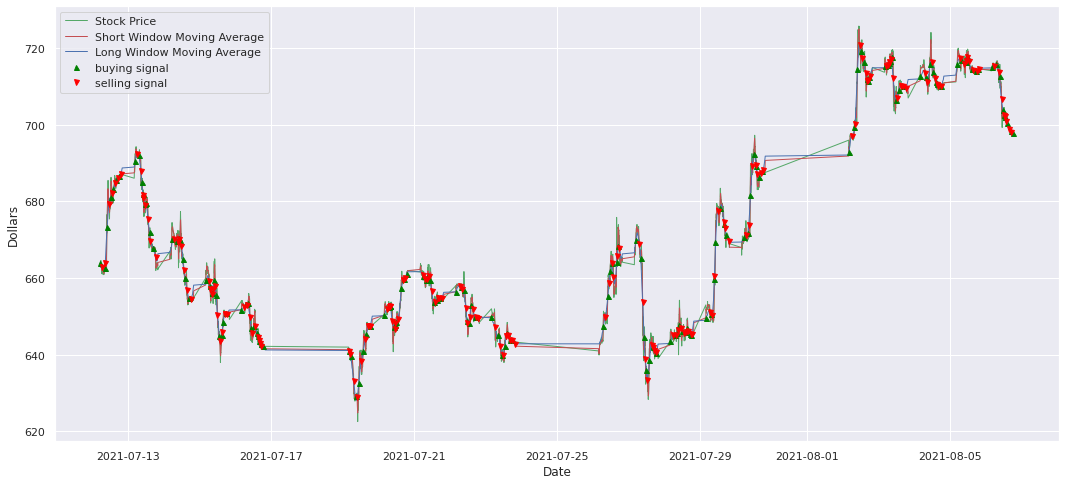

In [162]:
SMA_TSLA_Figure = signal_figure(df_TSLA, Signal_TSLA)
SMA_Signal_TSLA =SMA_TSLA_Figure.signal_figure()

In [163]:
SMA_Signal_TSLA.head()

,close,signal,short_ma,long_ma,positions
date,,,,,
2021-07-12 05:20:00,663.69,1.0,663.830,662.811000,1.0
2021-07-12 05:40:00,664.60,1.0,663.240,662.874667,0.0
2021-07-12 06:10:00,662.70,0.0,662.830,662.841333,-1.0
2021-07-12 06:15:00,661.16,0.0,662.532,662.799667,0.0
2021-07-12 06:25:00,662.00,0.0,662.052,662.733000,0.0


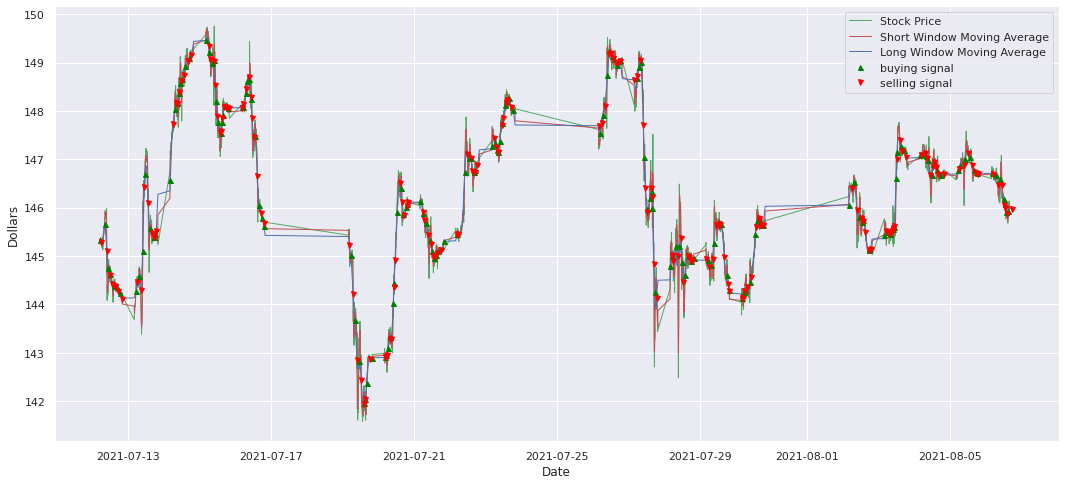

In [164]:
SMA_AAPL_Figure = signal_figure(df_AAPL, Signal_AAPL)
SMA_Signal_AAPL =SMA_AAPL_Figure.signal_figure()

In [165]:
SMA_Signal_AAPL.head()

,close,signal,short_ma,long_ma,positions
date,,,,,
2021-07-12 05:15:00,145.3811,1.0,145.32922,145.246000,1.0
2021-07-12 05:20:00,145.3512,1.0,145.32124,145.259313,0.0
2021-07-12 05:25:00,145.3013,1.0,145.31924,145.270630,0.0
2021-07-12 05:30:00,145.2913,1.0,145.31924,145.279950,0.0
2021-07-12 05:35:00,145.2713,1.0,145.31524,145.278287,0.0


# 3. Generate Return of Investment and Portfolio Flows (cash, holding and total)

program the portfolio class

In [168]:
class portfolio:
  def __init__(self,data,initial_capital=10000,max_buy=10000000,max_sell=10000000):
    self.data = data
    self.initial_capital = initial_capital
    self.max_buy = max_buy
    self.max_sell = max_sell
  def portfolios(self):
    management = self.data
    prices = self.data['close']
    states = self.data['positions']
    states_buy = []
    states_sell = []
    cashes = []
    stocks = []
    holdings = []
    cash = self.initial_capital
    stock = 0
    holding = 0
    state = 0
    def buy(i,cash,stock,price):
      shares = cash // price #shares to buy in integer
      if shares<1:
        print('order %d: total cash %f, not enough to buy 1 share at price %f' % (i, cash, price))
      else:
        if shares>self.max_buy:
            buy_units = self.max_buy
        else:
            buy_units = shares
        cost = buy_units*price
        cash -= cost
        stock += buy_units
        holding = stock*price
        print('index %d: buy %d units at price %f, current cash %f, current stock %f,current holding %f' % (i, buy_units, price, cash, stock, holding))
        return cash, stock, holding   
    def sell(i,cash, stock,price):
       if stock == 0:
         print('index %d: cannot sell anything, currentstock 0' % (i))
       else:
         if stock > self.max_sell:
            sell_units = self.max_sell
         else: 
            sell_units = stock
         stock -=sell_units
         revenue = sell_units*price
         cash += revenue
         holding = stock*price
         print('index %d: sell %d units at price %f, current cash %f, current stock %f,current holding %f' % (i, sell_units, price, cash, stock, holding))
         return cash, stock, holding
    for i in range(0,management.shape[0]):
      
      state = states[i]
      price = prices[i]
      if state == 1:
        cash, stock, holding = buy(i, cash, stock, price)
        states_buy.append(i)
      elif state == -1:
        cash, stock, holding = sell(i,cash, stock, price)
      states_sell.append(i)
      cashes.append(cash)
      stocks.append(stock)
      holdings.append(holding)
    
    management['cash']=cashes
    management['stock']=stocks
    management['holding']=holdings
    management['total']=management['cash']+management['holding']
    management['roi']=(management['total']-self.initial_capital)/self.initial_capital
    fig, (ax1, ax2) = plt.subplots(1, 2, sharey=False)
    ax1=management[['holding', 'cash', 'total']].plot(figsize=(14, 10),legend=True)
    ax2=management[['roi']].plot(figsize=(14, 10),legend=True)
    return management
 

Return plots with input data.

We use Tesla (TSLA) and Apple (AAPL) with 5-min time interval as case studies.

Short_window =5

Long_window =30

index 0: buy 15 units at price 663.690000, current cash 44.650000, current stock 15.000000,current holding 9955.350000
index 2: sell 15 units at price 662.700000, current cash 9985.150000, current stock 0.000000,current holding 0.000000
index 23: buy 15 units at price 662.080500, current cash 53.942500, current stock 15.000000,current holding 9931.207500
index 27: sell 15 units at price 663.800000, current cash 10010.942500, current stock 0.000000,current holding 0.000000
index 41: buy 14 units at price 676.560000, current cash 539.102500, current stock 14.000000,current holding 9471.840000
index 56: sell 14 units at price 678.914700, current cash 10043.908300, current stock 0.000000,current holding 0.000000
index 70: buy 14 units at price 681.237900, current cash 506.577700, current stock 14.000000,current holding 9537.330600
index 81: sell 14 units at price 682.008900, current cash 10054.702300, current stock 0.000000,current holding 0.000000
index 93: buy 14 units at price 683.87330

,close,signal,short_ma,long_ma,positions,cash,stock,holding,total,roi
date,,,,,,,,,,
2021-07-12 05:20:00,663.69,1.0,663.830,662.811000,1.0,44.65,15.0,9955.35,10000.00,0.000000
2021-07-12 05:40:00,664.60,1.0,663.240,662.874667,0.0,44.65,15.0,9955.35,10000.00,0.000000
2021-07-12 06:10:00,662.70,0.0,662.830,662.841333,-1.0,9985.15,0.0,0.00,9985.15,-0.001485
2021-07-12 06:15:00,661.16,0.0,662.532,662.799667,0.0,9985.15,0.0,0.00,9985.15,-0.001485
2021-07-12 06:25:00,662.00,0.0,662.052,662.733000,0.0,9985.15,0.0,0.00,9985.15,-0.001485


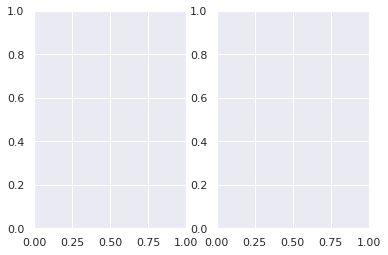

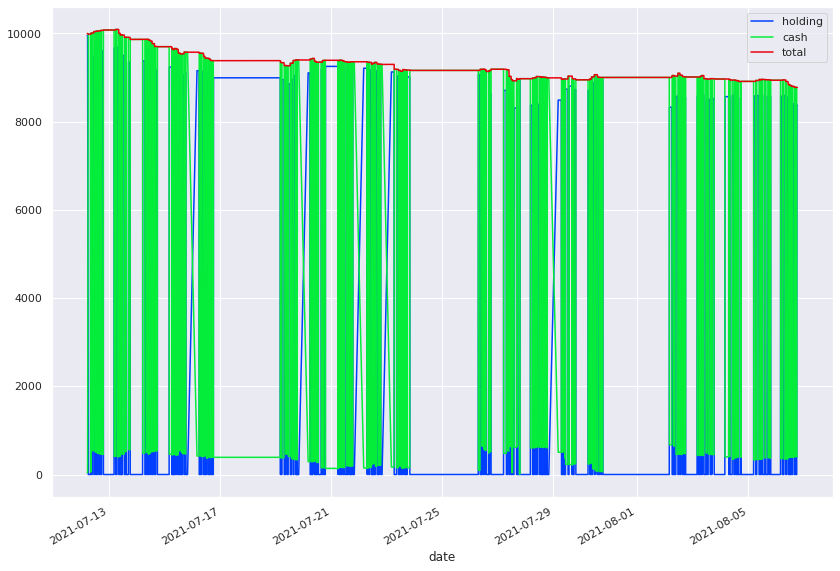

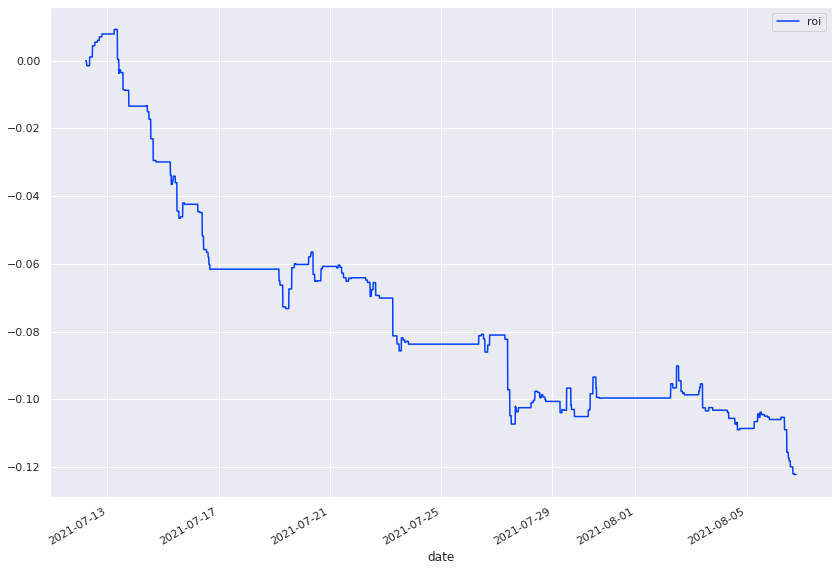

In [169]:
SMA_TSLA_Portfolio = portfolio(SMA_Signal_TSLA)
TSLA_Portfolio = SMA_TSLA_Portfolio.portfolios()
TSLA_Portfolio.head()

index 0: buy 68 units at price 145.381100, current cash 114.085200, current stock 68.000000,current holding 9885.914800
index 9: sell 68 units at price 145.311200, current cash 9995.246800, current stock 0.000000,current holding 0.000000
index 33: buy 68 units at price 145.630800, current cash 92.352400, current stock 68.000000,current holding 9902.894400
index 52: sell 68 units at price 145.091600, current cash 9958.581200, current stock 0.000000,current holding 0.000000
index 64: buy 68 units at price 144.876900, current cash 106.952000, current stock 68.000000,current holding 9851.629200
index 73: sell 68 units at price 144.532400, current cash 9935.155200, current stock 0.000000,current holding 0.000000
index 79: buy 68 units at price 144.632300, current cash 100.158800, current stock 68.000000,current holding 9834.996400
index 95: sell 68 units at price 144.427600, current cash 9921.235600, current stock 0.000000,current holding 0.000000
index 107: buy 68 units at price 144.347700

,close,signal,short_ma,long_ma,positions,cash,stock,holding,total,roi
date,,,,,,,,,,
2021-07-12 05:15:00,145.3811,1.0,145.32922,145.246000,1.0,114.0852,68.0,9885.9148,10000.0,0.0
2021-07-12 05:20:00,145.3512,1.0,145.32124,145.259313,0.0,114.0852,68.0,9885.9148,10000.0,0.0
2021-07-12 05:25:00,145.3013,1.0,145.31924,145.270630,0.0,114.0852,68.0,9885.9148,10000.0,0.0
2021-07-12 05:30:00,145.2913,1.0,145.31924,145.279950,0.0,114.0852,68.0,9885.9148,10000.0,0.0
2021-07-12 05:35:00,145.2713,1.0,145.31524,145.278287,0.0,114.0852,68.0,9885.9148,10000.0,0.0


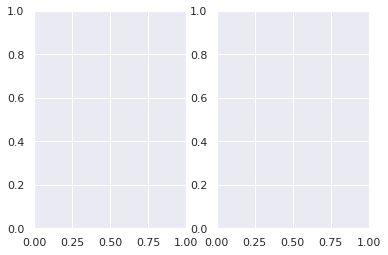

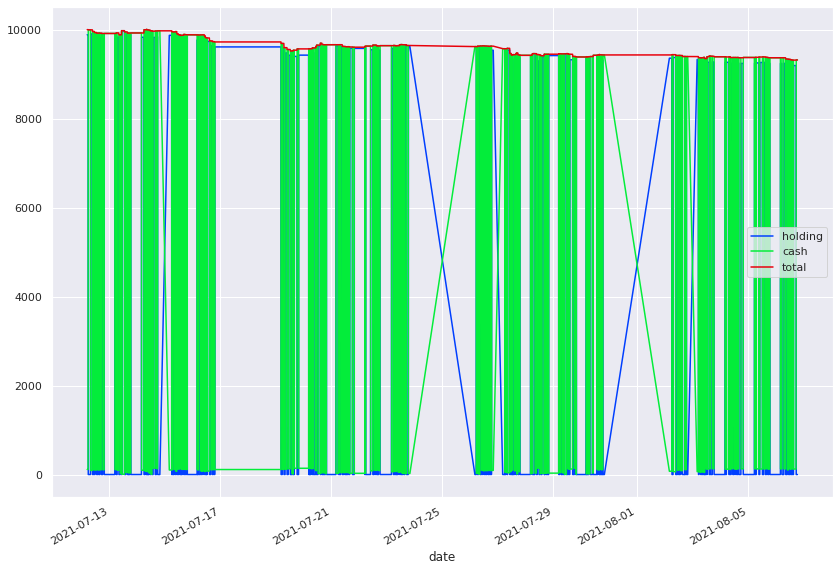

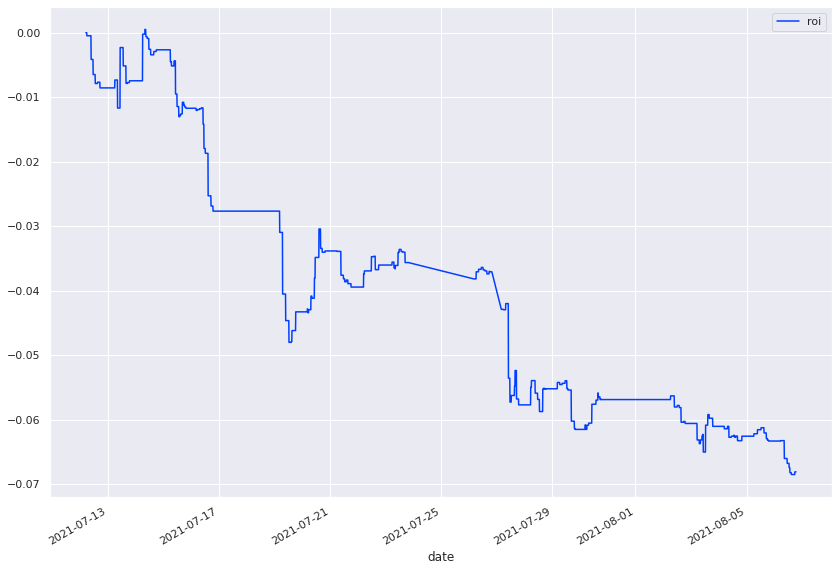

In [170]:
SMA_AAPL_Portfolio = portfolio(SMA_Signal_AAPL)
AAPL_Portfolio = SMA_AAPL_Portfolio.portfolios()
AAPL_Portfolio.head()